# <center> Stream Max Movie Selection Modeling and Recommender Project
### <center>ADS 505 Fall 2022</center>
**<center>Ivan Chavez</center>**
**<center>Azucena Faus</center>**
**<center>Sanjay Regi Philip</center>**

In [1137]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import dmba
from pathlib import Path
import functools as ft
import string
import re
import spacy
import scikitplot as skplt
import plotly.graph_objs as go

from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from plotly.offline import init_notebook_mode, plot, iplot
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules


from dmba import regressionSummary
from dmba import adjusted_r2_score, AIC_score, BIC_score
from dmba import backward_elimination, forward_selection, stepwise_selection
from plotly.offline import init_notebook_mode, plot, iplot

from dmba import plotDecisionTree, classificationSummary, regressionSummary
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity

from surprise import Dataset
from surprise import Reader
from surprise import KNNBasic

from dmba import gainsChart, liftChart
from ast import literal_eval

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

## Business Problem:

*Business Status and Surveys:*

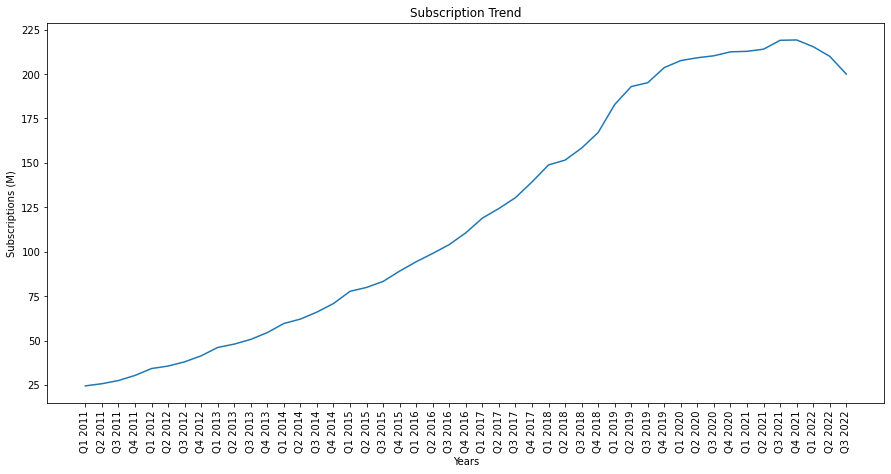

In [952]:
# Subscriber trends over time:

Monthly_Subscriptions=[24.480,25.7,27.49,
                       30.36,34.24,35.64,38,41.4,46.1,47.99,50.65,54.48,
                       59.6,62.08,66.02,70.84,77.7,79.9,83.28,89.09,94.36,
                       99.04,104.02,110.64,118.9,124.34,130.42,139.26,148.86,151.56,
                       158.33,167.09,182.86,192.95,195.15,203.67,207.6,209.18,210.3,
                       212.5,212.8,214,219,219.2,215.4,210,200]
#Yearly_Subscriptions=
months=['September 2021','October 2021',
       'November 2021','December 2021','January 2022','February 2022',
       'March 2022','April 2022','May 2022','June 2022',
       'July 2022','August 2022']
years_quarters=['Q1 2011','Q2 2011','Q3 2011','Q4 2011','Q1 2012',
       'Q2 2012','Q3 2012','Q4 2012','Q1 2013','Q2 2013','Q3 2013',
       'Q4 2013','Q1 2014','Q2 2014','Q3 2014','Q4 2014','Q1 2015',
       'Q2 2015','Q3 2015','Q4 2015','Q1 2016','Q2 2016','Q3 2016',
       'Q4 2016','Q1 2017','Q2 2017','Q3 2017','Q4 2017','Q1 2018',
       'Q2 2018','Q3 2018','Q4 2018','Q1 2019','Q2 2019','Q3 2019',
       'Q4 2019','Q1 2020','Q2 2020','Q3 2020','Q4 2020','Q1 2021',
       'Q2 2021','Q3 2021','Q4 2021','Q1 2022','Q2 2022','Q3 2022']
 

fig, ax = plt.subplots(figsize=(15,7))

plt.title('Subscription Trend')
ax.plot(years_quarters, Monthly_Subscriptions)
plt.xlabel('Years')
plt.xticks(rotation=90)
plt.ylabel('Subscriptions (M)')
#ax.plot(x, ratings_them)
plt.show()

*Last 3 Quarters we lost 19M subscribers*

### Customer Survey:

To find the possible reasons for subscriber loss

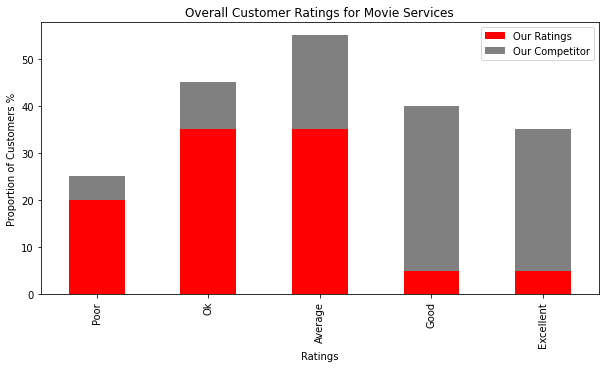

In [934]:
# Customer satisfaction:

x = [1, 2, 3, 4, 5]
ratings_us = [20, 35, 35, 5, 5]
ratings_them = [5, 10, 20, 35, 30]
Rating_Overall_Business = pd.DataFrame({'Our Ratings': [20, 35, 35, 5, 5],
                   'Our Competitor': [5, 10, 20, 35, 30]},
                  index=['Poor', 'Ok', 'Average', 'Good', 'Excellent'])

#fig, ax = plt.subplots()
Rating_Overall_Business.plot(kind='bar', stacked=True, color=['red', 'gray'],
                      figsize=(10,5))
 
# labels for x & y axis
plt.xlabel('Ratings')
plt.ylabel('Proportion of Customers %')
 
# title of plot
plt.title('Overall Customer Ratings for Movie Services')
plt.show()

*Upon comparing our ratings from customers to their perceived rating of our competitor, it is apparent there is a problem with our ratings*

### Noteworthy Specifics from Survey:

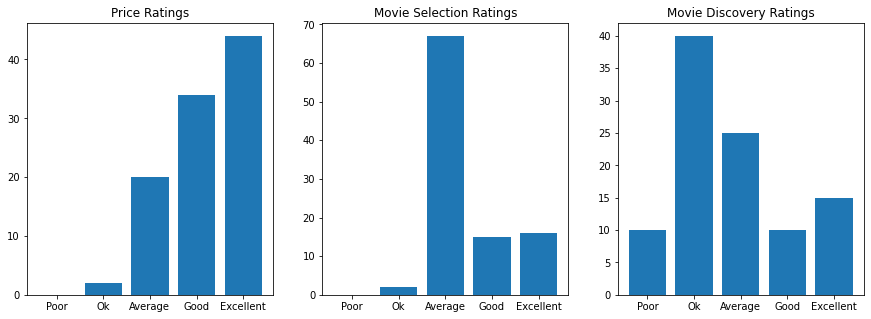

In [987]:
# Specific Survey results:

Rating_Importance = pd.DataFrame({'Price': [0, 2, 20, 34, 44],
                                 'Movie_Selection': [0, 2, 67, 15, 16],
                                 'Ease_of_finding_new_movies': [10, 40, 25, 10, 15]},
                  index=['Poor', 'Ok', 'Average', 'Good', 'Excellent'])

fig, ax = plt.subplots(1,3,figsize=(15,5))


#plt.show()
ax[0].bar(Rating_Importance.index,Rating_Importance.Price)
ax[1].bar(Rating_Importance.index,Rating_Importance.Movie_Selection)
ax[2].bar(Rating_Importance.index,Rating_Importance.Ease_of_finding_new_movies)


ax[0].title.set_text('Price Ratings') 
ax[1].title.set_text('Movie Selection Ratings') 
ax[2].title.set_text('Movie Discovery Ratings') 
ax=plt.show()

*The survey questions arose from comments in the lowest ratings and was collected over the same group of customers who sent the initial results. We can see our two areas of improvement are the Movie Selection and Movie Discovery.*

*Results:*

We see that we must improve our movie selection by choosing to add movies with higher predicted ratings than just the most recent. Also, we must have a way to help our customers discover new favorites without having to search the entire database of movies.

We will accomplish this through a movie ratings prediction algorithm that will be run on any new available selection of movies so we can only add those we are confident will be highly appreciated by our customer base, and a recommender system to use the current customer data ratings on movies already watched and recommend the top 3 or 4 movies that match with our customers' high-rated movies.

The data for movie rating prediction was based on 270,896 customer movie ratings and movie collections.
The data used for the recommender system was based on 671 customer ratings for movies.


----

## EDA

In [1097]:
keywords_df = pd.read_csv('keywords.csv')
links_df = pd.read_csv('links.csv')
credits_df = pd.read_csv('credits.csv')
movie_meta_df = pd.read_csv('movies_metadata.csv')
movie_meta_df.sample(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
35387,False,"{'id': 77816, 'name': 'Kung Fu Panda Collectio...",145000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.kungfupanda.com/,140300,tt2267968,en,Kung Fu Panda 3,"Continuing his ""legendary adventures of awesom...",...,2016-01-23,521170825.0,95.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Grab destiny by the rice dumplings.,Kung Fu Panda 3,False,6.7,1630.0
5960,False,NaN,0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,29450,tt0084302,sr,Maratonci trče počasni krug,The Topalovic family has been in the burial bu...,...,1982-01-01,0.0,92.0,"[{'iso_639_1': 'sr', 'name': 'Srpski'}]",Released,NaN,The Marathon Family,False,7.8,16.0
7604,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 53, 'name...",NaN,87677,tt0157913,en,La Cucaracha,A desperate writer fights for survival when th...,...,1998-05-14,0.0,97.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It's High Noon in Hell,La Cucaracha,False,3.8,3.0
27636,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",http://modrisfilm.com/,287504,tt3657970,en,Modris,In this tough but compassionate coming-of-age ...,...,2014-10-24,0.0,98.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}, {'iso...",Released,NaN,Modris,False,5.0,1.0
38149,False,NaN,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",http://www.unnovioparamimujer.com/,16916,tt1280534,es,Un novio para mi mujer,El Tenso does not know how to face his ill-tem...,...,2008-08-14,0.0,100.0,"[{'iso_639_1': 'es', 'name': 'Español'}]",Released,NaN,A Boyfriend for My Wife,False,6.2,18.0


In [508]:
ratings_df = pd.read_csv('ratings.csv')

In [992]:
len(ratings_df['userId'].unique())

270896

In [991]:
ratings_small_df['userId'].unique()

[1, 2, 3, 4, 5, ..., 667, 668, 669, 670, 671]
Length: 671
Categories (671, int64): [1, 2, 3, 4, ..., 668, 669, 670, 671]

In [525]:
ratings_small_df.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


### Averge/Count relationships for Votes/Rates:

Text(0.5, 0.98, 'Relationship between Vote_Average and Vote_Count in Movie MetaData')

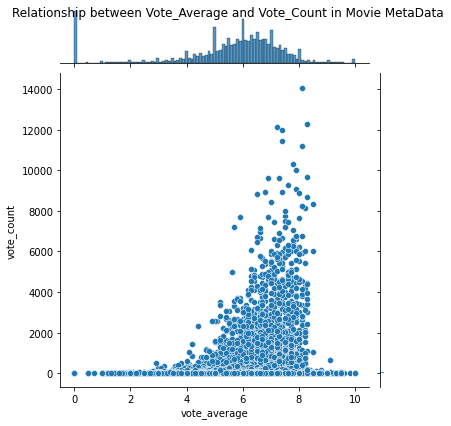

In [993]:
p=sns.jointplot(x='vote_average',y='vote_count', data=movie_meta_df)
p.fig.suptitle("Relationship between Vote_Average and Vote_Count in Movie MetaData")

In [529]:
# plot the rating avg vs rating count
# for our rating data:

ratings['rating_avg'] = pd.DataFrame(ratings_df.groupby('movieId')['rating'].mean())


ratings['rating_count'] = ratings_df.groupby('movieId')['rating'].count()
ratings.head()

,rating,number_of_ratings,rating_avg,rating_count
movieId,,,,
1,3.888157,66008,3.888157,66008
2,3.236953,26060,3.236953,26060
3,3.175550,15497,3.175550,15497
4,2.875713,2981,2.875713,2981
5,3.079565,15258,3.079565,15258


Text(0.5, 0.98, 'Relationship between Rating Average and Rating Count in Ratings Dataset')

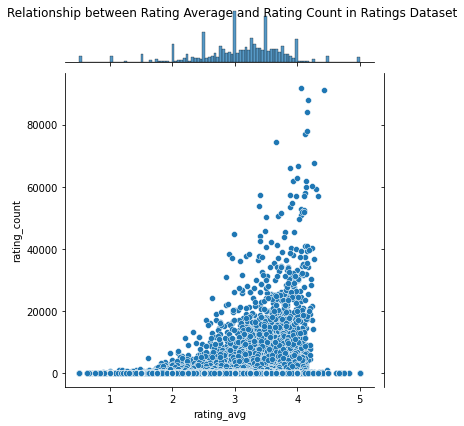

In [994]:
q=sns.jointplot(x='rating_avg', y='rating_count', data=ratings)
q.fig.suptitle("Relationship between Rating Average and Rating Count in Ratings Dataset")

*Results:*

We can see as the ratings increase, the number of people that rate the movie also increases. This is the case with both the overall movie metadata (movie_meta_df dataframe) and current customer ratings for those movies (from the ratings_df dataframe)

### Move Rating Distributions:

In [998]:
init_notebook_mode(connected=True)

data = ratings_small_df['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / ratings_small_df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution of Movie Ratings'.format(ratings_small_df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [999]:
# Number of ratings per movie:
data = ratings_small_df.groupby('movieId')['rating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Movie (Clipped at 50)',
                   xaxis = dict(title = 'Number of Ratings Per Movie'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [671]:
rating_count = ratings_small_df.groupby('movieId')['rating'].count().reset_index()
rating_count_top10=rating_count.sort_values('rating', ascending=False)[:10]

In [672]:
rating_count_top10

,movieId,rating
321,356,341
266,296,324
284,318,311
525,593,304
232,260,291
427,480,274
2062,2571,259
0,1,247
472,527,244
522,589,237


### Top 10 movie ratings:

In [683]:
# Correlate movieId from ratings dataset
# to the imdbId in the links dataset:

top10=[]
top10_movieId=rating_count_top10['movieId'].reset_index()

for s in range(0,len(rating_count_top10)):
    index_links_top10=links_df['movieId']==top10_movieId['movieId'][s]

    top10_imdb=links_df['imdbId'][index_links_top10].astype('string')
#    top10_imdb_string=top10_imdb.values[0]
#    top10_imdb_movie= [f"tt0{top10_imdb_string}"]
    top10.append(top10_imdb.values[0])


# Find the movie title related to the
# newfound imdbId in the movie_meta_df
# dataset and add it to the top 10 rated
# movie titles:

top10_titles=[]

for i in range(0,len(top10)):
    
    index_movie_top10=movie_meta_df.loc[movie_meta_df['imdb_id'].str.contains(top10[i], case=False)].index

    top10_title=movie_meta_df['title'][index_movie_top10]
    top10_title_string=top10_title.values[0]
    top10_titles.append(top10_title_string)

rating_count_top10['movie_title']=top10_titles



In [684]:
rating_count_top10

,movieId,rating,movie_title
321,356,341,Forrest Gump
266,296,324,Pulp Fiction
284,318,311,The Shawshank Redemption
525,593,304,The Silence of the Lambs
232,260,291,Star Wars
427,480,274,Jurassic Park
2062,2571,259,The Matrix
0,1,247,Toy Story
472,527,244,Schindler's List
522,589,237,Terminator 2: Judgment Day


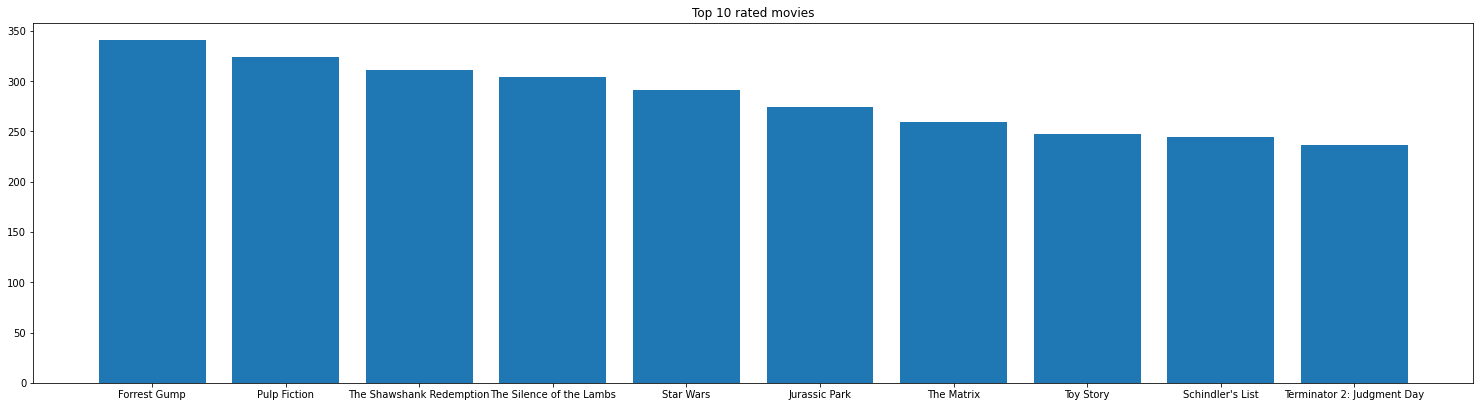

In [699]:

fig = plt.figure(figsize=(20,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(rating_count_top10['movie_title'],rating_count_top10['rating'])
plt.title('Top 10 rated movies')
plt.show()

-------

## Recommender

### item-item collaborative filtering

In [702]:
ratings_small_df.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [537]:
movie_mod=movie_meta_df[['movieId','vote_average']]

In [708]:
ratings_small_df['movieId']=ratings_small_df['movieId'].astype('category')
ratings_small_df['userId']=ratings_small_df['userId'].astype('category')

#### Generate the collaborative filter model:

In [744]:
reader = Reader(rating_scale=(0, 6))
data = Dataset.load_from_df(ratings_small_df, reader)
trainset = data.build_full_trainset()

# compute cosine similarities between items
sim_options = {'name': 'cosine', 'user_based': False}  
algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [739]:
movies = links_df.movieId
movies

0             1
1             2
2             3
3             4
4             5
          ...  
45838    176269
45839    176271
45840    176273
45841    176275
45842    176279
Name: movieId, Length: 45843, dtype: int64

#### Run the predictions one one user:

In [748]:
movies = links_df.movieId
predictions2=pd.DataFrame(columns = ['user','new_movie','predicted_rating'])

for mov in movies: 
    #print(movies, algo.predict(1, movies).est >=4)
    predicted2 = algo.predict(2, mov).est 
    if predicted2 >= 4:
        highest_rated_index2 = predicted2
        print(mov, predicted2)
        predictions2.loc[len(predictions2.index)] = ['2', mov, predicted2] 
        #predictions2.append(mov)

        #highest_rated1=movies[highest_rated_index1]
predictions2.sort_values('predicted_rating', ascending=False)[:4]
#predicted_rec=movies[predictions]
#print(highest_rated1)

84 4.0
439 5.0
559 4.0
573 4.0
681 4.0
690 4.0
721 4.0
760 4.0
793 4.0
820 4.0
845 4.0
854 4.0
872 4.0
1040 4.0
1174 4.0
1328 5.0
1444 4.0
1472 4.0
1636 5.0
1733 4.0
2246 4.111111111111111
2562 4.0
3349 4.0
3454 4.5
3474 4.0
3628 4.0
3637 4.0
3766 4.077038156072072
3768 4.0
3780 4.0
3829 4.0
3879 4.0
3885 4.0
4045 4.0
4181 5.0
4466 4.0
4470 4.0
4475 4.25
4521 4.0
4527 5.0
4550 5.0
4559 5.0
4578 5.0
4945 4.0
5422 5.0
5605 4.0
5788 4.0
5834 5.0
5910 4.0
5917 4.0
5958 4.0
5969 5.0
6012 4.0
6014 4.0
6154 4.0
6332 4.5
6509 4.0
7051 4.0
7086 4.0
7172 4.0
7340 4.166666666666667
7453 4.5
7564 4.0
7574 4.0
7773 5.0
7786 4.0
7820 4.0
7919 4.0
8484 4.0
8485 4.0
8629 4.0
8642 4.5
8765 4.0
8982 4.0
25763 4.0
26150 4.0
26228 4.0
26265 4.0
26578 4.0
26903 4.0
27251 5.0
31524 4.0
31930 4.0
32456 4.0
33158 4.0
33296 4.5
37475 4.0
39408 5.0
39416 5.0
40491 4.0
43899 4.0
44225 4.5
44731 5.0
45000 4.0
45969 4.0
47122 4.5
50954 4.2
51939 4.0
52528 4.0
52617 4.0
54734 4.5
54780 4.0
55100 4.5
58425 4.0
58655

,user,new_movie,predicted_rating
80,2,27251,5.0
15,2,1328,5.0
88,2,39416,5.0
87,2,39408,5.0


In [753]:
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [759]:
top4_movieId


,index,new_movie
0,80,27251
1,15,1328
2,88,39416
3,87,39408


#### Add Movie titles for one user:

In [751]:
top4_predictions_user2 = predictions2.sort_values('predicted_rating', ascending=False)[:4]

In [760]:
# For an individual user:

top4_movieId=top4_predictions_user2['new_movie'].reset_index()
top4_titles=[]

for ee in range(0,len(top4_predictions_user2)):
    index_links_top4=links_df['movieId']==top4_movieId['new_movie'][ee]

    top4_imdb=links_df['imdbId'][index_links_top4].astype('string')
        
    top4=top4_imdb.values[0]

    index_movie_top4=movie_meta_df.loc[movie_meta_df['imdb_id'].str.contains(top4, case=False)].index

    top4_title=movie_meta_df['title'][index_movie_top4]
    top4_title_string=top4_title.values[0]
    top4_titles.append(top4_title_string)


top4_predictions_user2['movie_title']=top4_titles


In [761]:
top4_predictions_user2

,user,new_movie,predicted_rating,movie_title
80,2,27251,5.0,The 10th Kingdom
15,2,1328,5.0,The Amityville Curse
88,2,39416,5.0,Kids in America
87,2,39408,5.0,Left Behind III: World at War


*Automate:*

In [763]:
ratings_small_df['userId'].unique()

[1, 2, 3, 4, 5, ..., 667, 668, 669, 670, 671]
Length: 671
Categories (671, int64): [1, 2, 3, 4, ..., 668, 669, 670, 671]

### Predict top 4 on entire dataset:

In [796]:
# Automate and run on entire ratings_small_df:

movies = links_df.movieId
predictions_all=pd.DataFrame()
    
for user in ratings_small_df['userId'].unique():

    predictions_user=pd.DataFrame(columns=['user','new_movie','predicted_rating'])
                                 
    for mov in movies:
        predictedUSER = algo.predict(user, mov).est 
    
        if predictedUSER >= 4:
            highest_rated_indexUSER = predictedUSER
            predictions_user.loc[len(predictions_user.index)] = [user, mov, predictedUSER] 

    
    top_4_USER = predictions_user.sort_values('predicted_rating', ascending=False)[:4]
    predictions_all=pd.concat([predictions_all, top_4_USER], ignore_index=True, sort=False)

predictions_all.columns = ['user','new_movie','predicted_rating']


In [798]:
predictions_all.shape

(2650, 3)

In [802]:
predictions_user

,user,new_movie,predicted_rating
0,671.0,1.0,4.100628
1,671.0,7.0,4.011990
2,671.0,9.0,4.099485
3,671.0,10.0,4.012579
4,671.0,17.0,4.110051
...,...,...,...
3972,671.0,161918.0,4.087500
3973,671.0,161944.0,4.375000
3974,671.0,162542.0,4.500000
3975,671.0,162672.0,4.500000


In [801]:
predictions_all.tail()

,user,new_movie,predicted_rating
2645,670.0,4593.0,5.0
2646,671.0,134783.0,4.833333
2647,671.0,39416.0,4.833333
2648,671.0,5422.0,4.833333
2649,671.0,127124.0,4.833333


In [805]:
predictions_all.to_csv('Top4_MovieRecs.csv')

In [812]:
predictions_all['new_movie']=predictions_all['new_movie'].astype('int')

In [843]:
predictions_all.iloc[48]

user                13.0
new_movie           1133
predicted_rating     5.0
Name: 48, dtype: object

In [844]:
index_curious=links_df['movieId']==1133
links_df[index_curious]

,movieId,imdbId,tmdbId
1110,1133,111357,NaN


In [846]:
movie_meta_df['imdb_id']=movie_meta_df['imdb_id'].astype('string')
index_weirdi=movie_meta_df.loc[movie_meta_df['imdb_id'].str.contains('11357', case=False)].index
movie_meta_df['title'][index_weirdi]

27946    Kristin Lavransdatter
Name: title, dtype: object

In [850]:
# correcting erroneous data in links_df
links_df['imdbId'][index_curious]='11357'

In [847]:
index_curious2=links_df['imdbId']==11357
links_df[index_curious2]

,movieId,imdbId,tmdbId


In [851]:
links_df[index_curious]

,movieId,imdbId,tmdbId
1110,1133,11357,NaN


In [847]:
index_curious2=links_df['imdbId']==11357
links_df[index_curious2]

,movieId,imdbId,tmdbId


In [854]:
predictions_all.iloc[112]

user                29.0
new_movie           6776
predicted_rating     5.0
Name: 112, dtype: object

In [855]:
index_curious=links_df['movieId']==6776
links_df[index_curious]

,movieId,imdbId,tmdbId
6667,6776,282674,19666.0


In [881]:
movie_meta_df['imdb_id']=movie_meta_df['imdb_id'].astype('string')
index_weirdi=movie_meta_df.loc[movie_meta_df['imdb_id'].str.contains('22674', case=False)].index
movie_meta_df['imdb_id'][index_weirdi]

9360     tt0322674
20870    tt1422674
31044    tt2267454
Name: imdb_id, dtype: string

In [884]:
index_curious2=links_df['imdbId']==422674
links_df[index_curious2]

,movieId,imdbId,tmdbId
9412,27639,322674,16132.0


### Add movie titles:

In [885]:
movie_meta_df['imdb_id']=movie_meta_df['imdb_id'].astype('string')

top4_movie_ALL=predictions_all['new_movie'].reset_index()
top4_titlesALL=[]

for ee in range(0,len(predictions_all)):
    #print(ee)
    index_links_top4ALL=links_df['movieId']==top4_movie_ALL['new_movie'][ee]

    top4_imdbALL=links_df['imdbId'][index_links_top4ALL].astype('string')
        
    top4ALL=top4_imdbALL.values[0]

    index_movie_top4ALL=movie_meta_df.loc[movie_meta_df['imdb_id'].str.contains(top4ALL, case=False)].index

    if index_movie_top4ALL.empty:
        top4_titlesALL.append('NA')
    else:
        top4_titleALL=movie_meta_df['title'][index_movie_top4ALL]
        top4_title_stringALL=top4_titleALL.values[0]
        top4_titlesALL.append(top4_title_stringALL)


predictions_all['movie_title']=top4_titlesALL

In [886]:
predictions_all.head()

,user,new_movie,predicted_rating,movie_title
0,1.0,80,4.0,The White Balloon
1,1.0,72683,4.0,Tell Me Something
2,1.0,100843,4.0,A Coffee in Berlin
3,1.0,100106,4.0,The Pervert's Guide to Ideology
4,2.0,27251,5.0,The 10th Kingdom


*Save to a csv file:*

In [887]:
predictions_all.to_csv('Top4_MovieRecs_complete.csv')

### Remove titles not found in links_df

#### Every user will have at least 3 recommendations, at maximum, 4

In [896]:
index_curious3=predictions_all['movie_title']=='NA'
index_curious4=predictions_all[index_curious3].index
predictions_complete_all=predictions_all.drop(index_curious4, axis=0)

In [1006]:
predictions_complete_all.to_csv('Top4_MovieRecs_final.csv')

---

## Recommender Results:

How was the recommender outputs received by users?

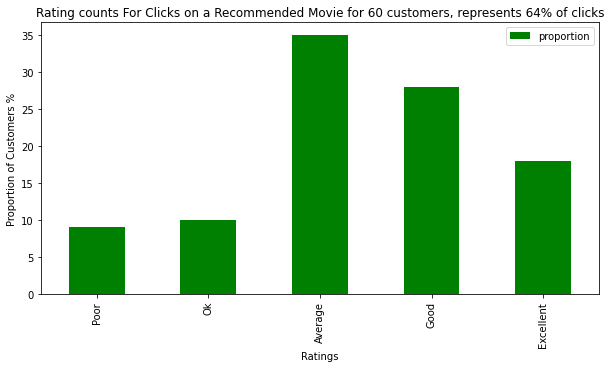

In [1043]:
# 10% of 671 customer dataset
# results form preliminary, soft 
# deployment of the recommdner system:

#x3 = 3*np.ones(35,1)
#x4 = 4*np.ones(28,1)
#x5 = 5*np.ones(18,1)
#x2 = 2*np.ones(10,1)
#x1 = np.ones(9,1)

no_clicks_recMovies = 180 #average of 3 per user
no_clicks_Wreviews = 115 #people rated less than avg of 2/3 clicks
#ratings_per_click=['x3','x4','x5','x2','x1']
Rating_Recommended_Clicks = pd.DataFrame({'proportion': [9, 10, 35, 28, 18]},
                  index=['Poor', 'Ok', 'Average', 'Good', 'Excellent'])

#fig, ax = plt.subplots()
Rating_Recommended_Clicks.plot(kind='bar', color=['green'],
                      figsize=(10,5))
 
# labels for x & y axis
plt.xlabel('Ratings')
plt.ylabel('Proportion of Customers %')
 
# title of plot
plt.title('Rating counts For Clicks on a Recommended Movie for 60 customers, represents 64% of clicks')
plt.show()

-----

In [ ]:
# do correlations matrix like in my notebook:

## Data Processing:

In [1098]:
# drop vote average and vote count
movie_meta_df=movie_meta_df.drop(columns=['vote_average', 'vote_count'])

In [1099]:
# dropping adult rated movies

filtered_rows = movie_meta_df[movie_meta_df['adult']=='True'].index
movie_meta_df = movie_meta_df.drop(index=filtered_rows)

# dropping adult column no longer needed
movie_meta_df = movie_meta_df.drop(columns='adult')

In [1100]:
# dropping movies that are not already Released
filtered_rows = movie_meta_df[movie_meta_df['status']!='Released'].index
movie_meta_df = movie_meta_df.drop(index=filtered_rows)

# dropping status column no longer needed with unreleased movies excluded
movie_meta_df = movie_meta_df.drop(columns='status')

In [1101]:
# dropping movies that are not already Released
filtered_rows = movie_meta_df[movie_meta_df['video']==True].index
movie_meta_df = movie_meta_df.drop(index=filtered_rows)
# dropping video column no longer needed
movie_meta_df = movie_meta_df.drop(columns='video')

In [450]:
movie_meta_df.head()

,belongs_to_collection,budget,genres,homepage,movieId,imdb_id,original_language,original_title,overview,popularity,...,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,vote_average,vote_count
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Toy Story,7.7,5415.0
1,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,Jumanji,6.9,2413.0
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,...,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,6.5,92.0
3,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,Waiting to Exhale,6.1,34.0
4,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,5.7,173.0


### Combine datasets:

In [1116]:


movie_meta_df['id']=movie_meta_df['id'].astype(int)
credits_df['id']=credits_df['id'].astype(int)
keywords_df['id']=keywords_df['id'].astype(int)


movies = pd.merge(movie_meta_df,credits_df, on='id', how='left')
movies = pd.merge(movies,keywords_df, on='id', how='left')


movies.head()

,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,production_countries,release_date,revenue,runtime,spoken_languages,tagline,title,cast,crew,keywords
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",NaN,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Roll the dice and unleash the excitement!,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Friends are the people who let you be yourself...,Waiting to Exhale,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [1117]:
links_df['id'] = links_df['tmdbId']
movies = pd.merge(movies,links_df, on='id', how='left')

In [1118]:
avg_ratings = round(ratings_df.groupby('movieId').mean(),2)

In [1119]:
movies = pd.merge(movies,avg_ratings, on='movieId', how='left')

movies.head()

,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,...,tagline,title,cast,crew,keywords,movieId,imdbId,tmdbId,userId,rating
0,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,...,NaN,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...","[{'id': 931, 'name': 'jealousy'}, {'id': 4290,...",1,114709,862.0,135121.04,3.89
1,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,...,Roll the dice and unleash the excitement!,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...","[{'id': 10090, 'name': 'board game'}, {'id': 1...",2,113497,8844.0,134877.95,3.24
2,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,...,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...","[{'id': 1495, 'name': 'fishing'}, {'id': 12392...",3,113228,15602.0,136520.45,3.18
3,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,...,Friends are the people who let you be yourself...,Waiting to Exhale,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...","[{'id': 818, 'name': 'based on novel'}, {'id':...",4,114885,31357.0,136249.54,2.88
4,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,...,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...","[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n...",5,113041,11862.0,135293.28,3.08


### Extract JSON features:

In [1120]:
features = ['cast', 'crew', 'genres', 'keywords']

movies = movies.dropna(subset=features)

#for feature in features:
#    movies[feature] = movies[feature].apply(literal_eval)
    
movies['cast'] = movies['cast'].apply(literal_eval)
movies['crew'] = movies['crew'].apply(literal_eval)
movies['keywords'] = movies['keywords'].apply(literal_eval)
movies['genres'] = movies['genres'].apply(literal_eval)


In [1121]:
## function to get name of director from the crew field
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

# get director
movies['director'] = movies['crew'].apply(get_director)
movies = movies.drop(columns='crew')

In [1122]:
# Returns the list of top 3 elements for genres and keywords
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [1123]:
features = ['cast', 'keywords', 'genres']

for feature in features:
    movies[feature] = movies[feature].apply(get_list)

In [1124]:
movies = movies.drop(columns=['belongs_to_collection', # this looks like an id column to me so not necessary to add
                     'homepage', # weblink so not needed
                     'id', # simple ID column not helpful for predicting
                     'imdb_id', # again an ID column
                     'original_title', # just a name
                     'overview', # we already have the top keywords as a column
                     'poster_path', # 
                     'production_companies', # 
                     'production_countries', #
                     'spoken_languages', # we have original language as a column - high correlation
                     'tagline', # we have keywords
#                     'title', # just a name    
                     'movieId' , 'imdbId', 'tmdbId']) # just more IDs  

In [1125]:
movies = movies.dropna()
movies.isnull().sum()

budget               0
genres               0
original_language    0
popularity           0
release_date         0
revenue              0
runtime              0
title                0
cast                 0
keywords             0
userId               0
rating               0
director             0
dtype: int64

### Encode:

In [1126]:
genres_cat = movies.genres.str.join('|').str.get_dummies().add_prefix('genres_')

In [1127]:
movies = pd.concat([movies, genres_cat], axis = 1)

In [1128]:
movies['Release_Year'] = movies['release_date'].str[:4]
movies['Release_Month'] = movies['release_date'].str[5:7]

In [1131]:
movies = pd.get_dummies(movies, columns=['Release_Year', 'Release_Month', 'original_language'])
movies

,budget,genres,popularity,release_date,revenue,runtime,title,cast,keywords,userId,...,original_language_tl,original_language_tr,original_language_uk,original_language_ur,original_language_uz,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu
0,30000000,"[Animation, Comedy, Family]",21.946943,1995-10-30,373554033.0,81.0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles]","[jealousy, toy, boy]",135121.04,...,0,0,0,0,0,0,0,0,0,0
1,65000000,"[Adventure, Fantasy, Family]",17.015539,1995-12-15,262797249.0,104.0,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst]","[board game, disappearance, based on children'...",134877.95,...,0,0,0,0,0,0,0,0,0,0
2,0,"[Romance, Comedy]",11.7129,1995-12-22,0.0,101.0,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret]","[fishing, best friend, duringcreditsstinger]",136520.45,...,0,0,0,0,0,0,0,0,0,0
3,16000000,"[Comedy, Drama, Romance]",3.859495,1995-12-22,81452156.0,127.0,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devine]","[based on novel, interracial relationship, sin...",136249.54,...,0,0,0,0,0,0,0,0,0,0
4,0,[Comedy],8.387519,1995-02-10,76578911.0,106.0,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short]","[baby, midlife crisis, confidence]",135293.28,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46334,0,[],0.003503,1917-10-21,0.0,87.0,Satan Triumphant,"[Iwan Mosschuchin, Nathalie Lissenko, Pavel Pa...",[],178373.00,...,0,0,0,0,0,0,0,0,0,0
35778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
35779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
35782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [1132]:
## remove variables that are not needed after encoding

movies = movies.drop(columns=['genres', 'release_date', 'cast', 'keywords', 'director'])

----

## Visualizations for Movie Characteristics:

In [1134]:
filter_col = [col for col in movies if col.startswith('genres')]

In [1135]:
movies[filter_col].columns

Index(['genres_Action', 'genres_Adventure', 'genres_Animation',
       'genres_Comedy', 'genres_Crime', 'genres_Documentary', 'genres_Drama',
       'genres_Family', 'genres_Fantasy', 'genres_Foreign', 'genres_History',
       'genres_Horror', 'genres_Music', 'genres_Mystery', 'genres_Romance',
       'genres_Science Fiction', 'genres_TV Movie', 'genres_Thriller',
       'genres_War', 'genres_Western'],
      dtype='object')

In [1049]:
movies_genre_counts=movies[filter_col].sum()


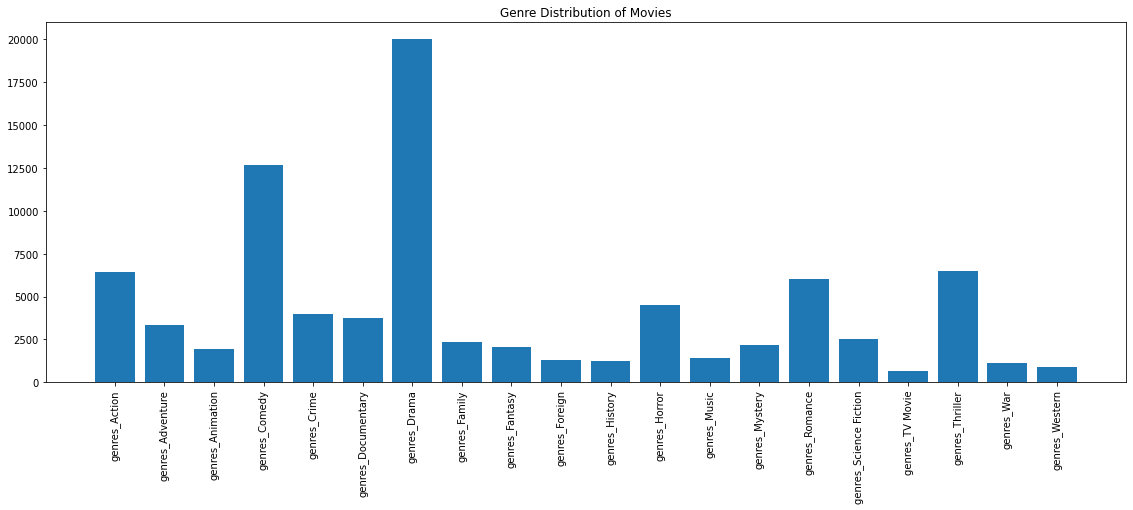

In [1056]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(movies[filter_col].columns,movies[filter_col].sum())
plt.title('Genre Distribution of Movies')
plt.xticks(rotation=90)
plt.show()

*Results:*

Drama and Comedy are the largest genre represented by our movie dataset.

### Cluster movie titles by genre

In [1157]:
movie_genre_clusters_df=movies[filter_col]
#movie_genre_clusters_df['title']=movies[['title']]
movie_genre_clusters_df.dropna(inplace=True)

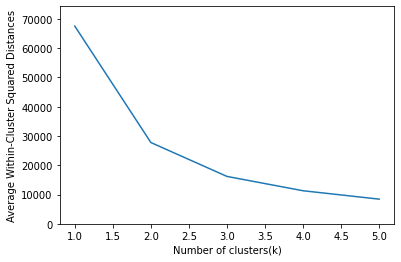

In [1158]:
inertia = []
for n_clusters in range(1, 6):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(movie_genre_clusters_df)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 6), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

In [1160]:
# k means
kmeans_movies = KMeans(n_clusters=3, random_state=0)
movie_genre_clusters_df['cluster'] = kmeans_movies.fit_predict(movie_genre_clusters_df)# get centroids
centroids = kmeans_movies.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
movie_genre_clusters_df['cen_x'] = movie_genre_clusters_df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
movie_genre_clusters_df['cen_y'] = movie_genre_clusters_df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
movie_genre_clusters_df['c'] = movie_genre_clusters_df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})

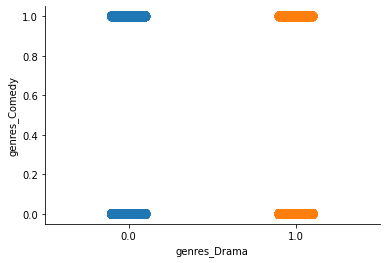

In [1165]:
sns.stripplot(x='genres_Drama',y='genres_Comedy',data=movie_genre_clusters_df, 
            c=movie_genre_clusters_df.c, alpha = 0.1, s=10, jitter=True)
sns.despine()

----

## Evaluate Recommender:

Find relationships between movies and those that are grouped as recommendations

In [1040]:
Recommender_predictions_df = pd.read_csv('Top4_MovieRecs_final.csv')

In [1039]:
movies.head()

,budget,popularity,revenue,runtime,title,userId,rating,genres_Action,genres_Adventure,genres_Animation,...,original_language_tl,original_language_tr,original_language_uk,original_language_ur,original_language_uz,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu
0,30000000,21.946943,373554033.0,81.0,Toy Story,135121.04,3.89,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,65000000,17.015539,262797249.0,104.0,Jumanji,134877.95,3.24,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,11.7129,0.0,101.0,Grumpier Old Men,136520.45,3.18,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,16000000,3.859495,81452156.0,127.0,Waiting to Exhale,136249.54,2.88,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,8.387519,76578911.0,106.0,Father of the Bride Part II,135293.28,3.08,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1042]:
Recommender_predictions_df.tail()

,Unnamed: 0,user,new_movie,predicted_rating,movie_title
2614,2645,670.0,4593,5.000000,Family Business
2615,2646,671.0,134783,4.833333,Entourage
2616,2647,671.0,39416,4.833333,Kids in America
2617,2648,671.0,5422,4.833333,The Emperor's New Clothes
2618,2649,671.0,127124,4.833333,I'll See You in My Dreams


In [1166]:
movie_genre_df=movies[filter_col]
movie_genre_df['title']=movies[['title']]
movie_genre_df.dropna(inplace=True)

In [1172]:
#index_genre=movie_genre_df.groupby(movie_genre_df['title']==Recommender_predictions_df['movie_title'])
#Recommender_predictions_df['genre']=movie_genre_df[index_genre]

-----

## Modeling:

### Train/Test Split:

In [291]:
trainData, testData = train_test_split(movies, test_size=0.2, random_state=1)

In [292]:
trainData.reset_index(drop=True, inplace=True)
testData.reset_index(drop=True, inplace=True)

In [293]:
print(trainData.shape)
print(testData.shape)

(35614, 259)
(8904, 259)


In [294]:
scaler = MinMaxScaler()

to_be_scaled = ['budget', 'popularity', 'revenue', 'runtime']

In [295]:
# training scaler ONLY on training data

train_scaled = scaler.fit_transform(trainData[to_be_scaled])

train_scaled = pd.DataFrame(train_scaled)

train_scaled.columns = to_be_scaled

# add scaled data back to dataframe
trainData = trainData.drop(columns=to_be_scaled)
trainData = pd.concat([trainData, train_scaled], axis = 1)

trainData.head()

,rating,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,...,original_language_uz,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu,budget,popularity,revenue,runtime
0,2.50,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0.000000,0.000004,0.0,0.064490
1,0.50,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0.000002,0.0,0.079618
2,2.00,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0.000208,0.0,0.075637
3,3.25,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000053,0.001045,0.0,0.027866
4,3.17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0.002123,0.0,0.000000


In [296]:
# fitting scaler on test data

test_scaled = scaler.transform(testData[to_be_scaled])

test_scaled = pd.DataFrame(test_scaled)

test_scaled.columns = to_be_scaled

# add scaled data back to dataframe
testData = testData.drop(columns=to_be_scaled)
testData = pd.concat([testData, test_scaled], axis = 1)

testData.head()

,rating,genres_Action,genres_Adventure,genres_Animation,genres_Comedy,genres_Crime,genres_Documentary,genres_Drama,genres_Family,genres_Fantasy,...,original_language_uz,original_language_vi,original_language_wo,original_language_xx,original_language_zh,original_language_zu,budget,popularity,revenue,runtime
0,2.75,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.0,0.000992,0.0,0.076433
1,3.40,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0.0,0.001789,0.0,0.071656
2,3.50,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.0,0.001147,0.0,0.091561
3,2.42,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0.0,0.004349,0.0,0.121019
4,4.50,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.0,0.011693,0.0,0.075637


*Model:*

In [310]:
#trainY =  round(trainData[['rating']],0)
#testY = round(testData[['rating']],0)

trainY =  trainData[['rating']]
testY = testData[['rating']]

trainX = trainData.drop(columns=['rating'])
testX = testData.drop(columns=['rating'])

In [309]:
trainX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35614 entries, 0 to 35613
Columns: 258 entries, genres_Action to runtime
dtypes: float64(4), int64(20), uint8(234)
memory usage: 14.5 MB


In [311]:
#Regression:

Trainy=trainY
Validy=testY

In [298]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(trainY)
Trainy=pd.DataFrame(enc.transform(trainY))
Validy=pd.DataFrame(enc.transform(testY))

In [305]:
Trainy.value_counts()

3.0    17272
4.0    10726
2.0     6279
1.0      720
0.0      342
5.0      275
dtype: int64

In [299]:
Trainy=Trainy.astype('category')
Validy=Validy.astype('category')


In [300]:
# partition the data 
#train_X_mov, valid_mov, train_y_mov, valid_y_mov = train_test_split(X_movies_dummies, 
#                                                          y_movies, 
#                                                          test_size=0.4, 
#                                                          random_state=1)

In [301]:
Tree_movies_team = DecisionTreeClassifier(max_depth=8)
Tree_movies_team.fit(trainX, Trainy)

DecisionTreeClassifier(max_depth=8)

In [312]:
# Regression:

Tree_movies_teamR = DecisionTreeRegressor(max_depth=8)
Tree_movies_teamR.fit(trainX, Trainy)

DecisionTreeRegressor(max_depth=8)

In [317]:
# Regression:

regressionSummary(Trainy, Tree_movies_teamR.predict(trainX))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.6480
            Mean Absolute Error (MAE) : 0.4748
          Mean Percentage Error (MPE) : -9.3637
Mean Absolute Percentage Error (MAPE) : 22.2648


In [318]:
regressionSummary(Validy, Tree_movies_teamR.predict(testX))


Regression statistics

                      Mean Error (ME) : 0.0092
       Root Mean Squared Error (RMSE) : 0.6691
            Mean Absolute Error (MAE) : 0.4914
          Mean Percentage Error (MPE) : -9.2192
Mean Absolute Percentage Error (MAPE) : 22.7192


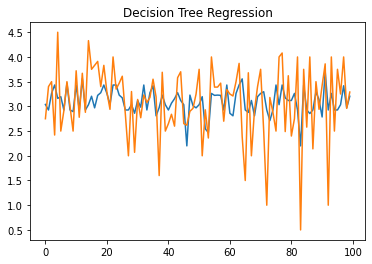

In [330]:
predict_R=pd.DataFrame(Tree_movies_teamR.predict(testX))
plt.figure()
plt.plot(predict_R.iloc[0:100])
plt.plot(Validy.iloc[0:100])

#plt.plot(Validy)
#plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
#plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
#plt.xlabel("data")
#plt.ylabel("target")
plt.title("Decision Tree Regression")
#plt.legend()
plt.show()

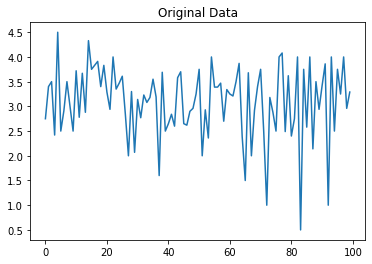

In [326]:
plt.figure()
#plt.plot(Tree_movies_teamR.predict(testX))
plt.plot(Validy.iloc[0:100])
#plt.plot(X_test, y_1, color="cornflowerblue", label="max_depth=2", linewidth=2)
#plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
#plt.xlabel("data")
#plt.ylabel("target")
plt.title("Original Data")
#plt.legend()
plt.show()

In [302]:
classificationSummary(Trainy, Tree_movies_team.predict(trainX))

Confusion Matrix (Accuracy 0.5386)

       Prediction
Actual     0     1     2     3     4     5
     0     1     0    70   241    30     0
     1     0    14   215   454    37     0
     2     0     1  1176  4683   419     0
     3     0     0   738 14520  2014     0
     4     0     1   213  7042  3470     0
     5     0     1    17   208    49     0


In [304]:
classificationSummary(Validy, Tree_movies_team.predict(testX))

Confusion Matrix (Accuracy 0.5201)

       Prediction
Actual    0    1    2    3    4    5
     0    0    0   25   58    6    0
     1    0    0   46  105   11    0
     2    0    5  257 1204  107    0
     3    0    1  194 3567  534    0
     4    0    0   60 1829  807    0
     5    0    0    7   67   14    0


parse dataset movies_df:

In [90]:
movies_df.shape

(45466, 24)

In [171]:
movies_df.isna().sum()

Te                          0
Ta                          0
Afrikaans                   0
Italian                     0
Japanese                    0
French                      0
English                     0
Horror_genre                0
Romance_genre               0
Animation_genre             0
Family_genre                0
Drama_genre                 0
Thriller_genre              0
Documentary_genre           0
Action_genre                0
Crime_genre                 0
War_genre                   0
Comedy_genre                0
adult                       0
budget                      0
genres                      0
id                          0
original_language          11
original_title              0
overview                  685
popularity                  0
production_companies        0
production_countries        0
release_date               72
revenue                     0
runtime                     0
spoken_languages            0
status                      0
tagline   

In [165]:
#movies_df=movies_df.copy()
movies_df=movies_df.drop(columns=['poster_path',
                                  'homepage',
                                  'belongs_to_collection',
                                  'imdb_id'])


In [166]:
# Remove the 6 records missing voting stats and revenue/language:

movies_df=movies_df.dropna(subset=['vote_average'])
movies_df=movies_df.dropna(subset=['status'])
movies_df=movies_df.dropna(subset=['runtime'])

In [93]:
movies_df['genres'].value_counts()

[{'id': 18, 'name': 'Drama'}]                                                                                                         5000
[{'id': 35, 'name': 'Comedy'}]                                                                                                        3621
[{'id': 99, 'name': 'Documentary'}]                                                                                                   2723
[]                                                                                                                                    2442
[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]                                                                       1301
                                                                                                                                      ... 
[{'id': 28, 'name': 'Action'}, {'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}, {'id': 99, 'name': 'Documentary'}]             1
[{'id': 10752, 'name': 'War

In [168]:
# Comedy, War, Action, Crime, History, 
# Documentary, Thriller, Drama,
# Family, Animation, Romance, Horror,


# Find rows with different genres and generate
# columns based on these features:

import re

ids = movies_df.genres.str.contains('Comedy', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Comedy_genre',0)
movies_df['Comedy_genre'].iloc[ids] = 1

ids_war = movies_df.genres.str.contains('War', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'War_genre',0)
movies_df['War_genre'].iloc[ids_war] = 1

ids_crime = movies_df.genres.str.contains('Crime', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Crime_genre',0)
movies_df['Crime_genre'].iloc[ids_crime] = 1

ids_action = movies_df.genres.str.contains('Action', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Action_genre',0)
movies_df['Action_genre'].iloc[ids_action] = 1

ids_documentary = movies_df.genres.str.contains('Documentary', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Documentary_genre',0)
movies_df['Documentary_genre'].iloc[ids_documentary] = 1

ids_thriller = movies_df.genres.str.contains('Thriller', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Thriller_genre',0)
movies_df['Thriller_genre'].iloc[ids_thriller] = 1

ids_drama = movies_df.genres.str.contains('Drama', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Drama_genre',0)
movies_df['Drama_genre'].iloc[ids_drama] = 1

ids_family = movies_df.genres.str.contains('Family', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Family_genre',0)
movies_df['Family_genre'].iloc[ids_family] = 1

ids_animation = movies_df.genres.str.contains('Animation', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Animation_genre',0)
movies_df['Animation_genre'].iloc[ids_animation] = 1

ids_romance = movies_df.genres.str.contains('Romance', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Romance_genre',0)
movies_df['Romance_genre'].iloc[ids_romance] = 1

ids_horror = movies_df.genres.str.contains('Horror', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Horror_genre',0)
movies_df['Horror_genre'].iloc[ids_horror] = 1


In [136]:
movies_df_final['spoken_languages'].value_counts()

[{'iso_639_1': 'en', 'name': 'English'}]                                                                                      22369
[]                                                                                                                             3680
[{'iso_639_1': 'fr', 'name': 'Français'}]                                                                                      1836
[{'iso_639_1': 'ja', 'name': '日本語'}]                                                                                           1288
[{'iso_639_1': 'it', 'name': 'Italiano'}]                                                                                      1192
                                                                                                                              ...  
[{'iso_639_1': 'bs', 'name': 'Bosanski'}, {'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'it', 'name': 'Italiano'}]        1
[{'iso_639_1': 'en', 'name': 'English'}, {'iso_639_1': 'ta', 'name': 'தமிழ்'

In [169]:

# Find rows with different languages spoken and generate
# columns based on these features:

ids_english = movies_df.spoken_languages.str.contains('English', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'English',0)
movies_df['English'].iloc[ids_english] = 1

ids_french = movies_df.spoken_languages.str.contains('Français', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'French',0)
movies_df['French'].iloc[ids_french] = 1

ids_japanese = movies_df.spoken_languages.str.contains('日本語', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Japanese',0)
movies_df['Japanese'].iloc[ids_japanese] = 1

ids_italian = movies_df.spoken_languages.str.contains('Italiano', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Italian',0)
movies_df['Italian'].iloc[ids_italian] = 1

ids_afrikaans = movies_df.spoken_languages.str.contains('Afrikaans', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Afrikaans',0)
movies_df['Afrikaans'].iloc[ids_afrikaans] = 1

ids_ta = movies_df.spoken_languages.str.contains('தமிழ்', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Ta',0)
movies_df['Ta'].iloc[ids_ta] = 1

ids_te = movies_df.spoken_languages.str.contains('తెలుగు', flags = re.IGNORECASE, regex = True, na = False)
movies_df.insert(0,'Te',0)
movies_df['Te'].iloc[ids_te] = 1

In [170]:
movies_df.reset_index(inplace=True, drop=True)

In [172]:
# Separate the release year from the 
# Release date:

yearreleased=[]

def conv_YearRelease(x):
    if pd.isnull(x): 
      # if there are nulls, exit out and return the null value
        return x
    
    sptreld = x.split('-') 
    yearreleased.append(sptreld[0]) 

    return yearreleased

In [173]:
movies_df['release_date'].apply(conv_YearRelease)
Year_Release=pd.DataFrame(yearreleased,columns=['Year_Released'])
movies_df=movies_df.join(Year_Release)

In [142]:
movies_df['release_date'].head()

0    1995-10-30
1    1995-12-15
2    1995-12-22
3    1995-12-22
4    1995-02-10
Name: release_date, dtype: object

In [131]:
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,Year_Released
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995


In [174]:
movies_df.isna().sum()

Te                          0
Ta                          0
Afrikaans                   0
Italian                     0
Japanese                    0
French                      0
English                     0
Horror_genre                0
Romance_genre               0
Animation_genre             0
Family_genre                0
Drama_genre                 0
Thriller_genre              0
Documentary_genre           0
Action_genre                0
Crime_genre                 0
War_genre                   0
Comedy_genre                0
adult                       0
budget                      0
genres                      0
id                          0
original_language          11
original_title              0
overview                  685
popularity                  0
production_companies        0
production_countries        0
release_date               72
revenue                     0
runtime                     0
spoken_languages            0
status                      0
tagline   

In [207]:
movies_df[['vote_average']]=round(movies_df[['vote_average']],0)

In [209]:
movies_df[['vote_averge']]=movies_df[['vote_average']].astype('category')

In [210]:
movies_df[['revenue','budget','runtime','popularity']] = movies_df[['revenue','budget','runtime','popularity']].astype(float)


In [93]:
movies_df['genres'].value_counts()

[{'id': 18, 'name': 'Drama'}]                                                                                                         5000
[{'id': 35, 'name': 'Comedy'}]                                                                                                        3621
[{'id': 99, 'name': 'Documentary'}]                                                                                                   2723
[]                                                                                                                                    2442
[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'name': 'Romance'}]                                                                       1301
                                                                                                                                      ... 
[{'id': 28, 'name': 'Action'}, {'id': 18, 'name': 'Drama'}, {'id': 35, 'name': 'Comedy'}, {'id': 99, 'name': 'Documentary'}]             1
[{'id': 10752, 'name': 'War

In [211]:
X_movies = movies_df.drop(columns=['overview','tagline','original_language',
                                  'original_title','production_companies',
                                  'production_countries','genres',
                                  'id','spoken_languages','title',
                                  'release_date'])
X_movies = X_movies.dropna()

In [212]:
y_movies=X_movies[['vote_average']]
X_movies=X_movies.drop(columns=['vote_average','vote_count'])

X_movies_dummies=pd.get_dummies(X_movies,drop_first=True)

In [213]:
X_movies_dummies.head()

,Te,Ta,Afrikaans,Italian,Japanese,French,English,Horror_genre,Romance_genre,Animation_genre,...,vote_averge_1.0,vote_averge_2.0,vote_averge_3.0,vote_averge_4.0,vote_averge_5.0,vote_averge_6.0,vote_averge_7.0,vote_averge_8.0,vote_averge_9.0,vote_averge_10.0
0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [214]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(y_movies)


OrdinalEncoder()

In [215]:
# partition the data 
train_X_mov, valid_mov, train_y_mov, valid_y_mov = train_test_split(X_movies_dummies, 
                                                          y_movies, 
                                                          test_size=0.4, 
                                                          random_state=1)

In [216]:
Tree_movies = DecisionTreeClassifier(max_depth=8)
Tree_movies.fit(train_X_mov, train_y_mov)

DecisionTreeClassifier(max_depth=8)

In [218]:
classificationSummary(train_y_mov, Tree_movies.predict(train_X_mov))

Confusion Matrix (Accuracy 0.9925)

       Prediction
Actual    0    1    2    3    4    5    6    7    8    9   10
     0 1815    0    0    0    0    0    0    0    0    0    0
     1   76    0    0    0    0    0    0    0    0    0    0
     2    0    0  249    0    0    0    0    0    0    0    0
     3    0    0    0  493    0    0    0    0    0    0    0
     4    0    0    0    0 2055    0    0    0    0    0    0
     5    0    0    0    0    0 4404    0    0    0    0    0
     6    0    0    0    0    0    0 9285    0    0    0    0
     7    0    0    0    0    0    0    0 6031    0    0    0
     8    0    0    0    0    0    0    0    0 2326    0    0
     9    0    0    0    0    0    0    0    0    0  170    0
    10  128    0    0    0    0    0    0    0    0    0    0


In [219]:
classificationSummary(valid_y_mov, Tree_movies.predict(valid_mov))

Confusion Matrix (Accuracy 0.9932)

       Prediction
Actual    0    1    2    3    4    5    6    7    8    9   10
     0 1066    0    0    0    0    0    0    0    0    0    0
     1   45    0    0    0    0    0    0    0    0    0    0
     2    0    0  158    0    0    0    0    0    0    0    0
     3    0    0    0  317    0    0    0    0    0    0    0
     4    0    0    0    0 1415    0    0    0    0    0    0
     5    0    0    0    0    0 2890    0    0    0    0    0
     6    0    0    0    0    0    0 6310    0    0    0    0
     7    0    0    0    0    0    0    0 4150    0    0    0
     8    0    0    0    0    0    0    0    0 1473    0    0
     9    0    0    0    0    0    0    0    0    0  121    0
    10   77    0    0    0    0    0    0    0    0    0    0


*Missing values:*

In [19]:
movies_df_final.isna().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

* The records with missing video/vote_avrage_vote_count/spoken_languages/revenue might be the same and so can probably be removed. If needed, the title column can be imputed by original_title, the spoken_languages by the original_language (if not missing).

* tagline missing 25k values might be too much to include
* belongs_to_collection is missing almost half the data, excluded from analysis?
* Not sure we need homepage - does that indicate popularity and does a missing value mean one does not exist?
* Three records are missing production_companies and production_countries which could probably be removed
* status has 87 missing values, unsure of options to impute


----

In [84]:
movies_df_final=movies_df.copy()
movies_df_final=movies_df_final.drop(columns=['poster_path',
                                              'homepage',
                                              'belongs_to_collection',
                                             'imdb_id'])


In [85]:
# Remove the 6 records missing voting stats and revenue/language:

movies_df_final=movies_df_final.dropna(subset=['vote_average'])
movies_df_final=movies_df_final.dropna(subset=['status'])
movies_df_final=movies_df_final.dropna(subset=['runtime'])

In [86]:
movies_df_final.isna().sum()

Te                          0
Ta                          0
Afrikaans                   0
Italian                     0
Japanese                    0
French                      0
English                     0
Horror_genre                0
Romance_genre               0
Animation_genre             0
Family_genre                0
Drama_genre                 0
Thriller_genre              0
Documentary_genre           0
Action_genre                0
Crime_genre                 0
War_genre                   0
Comedy_genre                0
adult                       0
budget                      0
genres                      0
id                          0
original_language          11
original_title              0
overview                  685
popularity                  0
production_companies        0
production_countries        0
release_date               72
revenue                     0
runtime                     0
spoken_languages            0
status                      0
tagline   

* for tagline and overview, will use NLP to generate some keyword count variables
* perhaps can impute original_language missing values only 11 cases (manually)
* same with release_date
* investigate runtime missing values
* investigate status missing values
* do we need the imdb id column?
* movieId in ratings column might match up to the id column better??


In [52]:
movies_df_final['id'].head()

0      862
1     8844
2    15602
3    31357
4    11862
Name: id, dtype: object

In [53]:
movies_df_final['imdb_id'].head()

0    tt0114709
1    tt0113497
2    tt0113228
3    tt0114885
4    tt0113041
Name: imdb_id, dtype: object

In [57]:
ratings_df['movieId'].head()

0     110
1     147
2     858
3    1221
4    1246
Name: movieId, dtype: int64

In [76]:
null_oglang= movies_df_final['original_language'].isna()
null_oglang_records = movies_df_final[null_oglang]
null_oglang_records['original_title']

19574       Shadowing the Third Man
21602                Unfinished Sky
22832               13 Fighting Men
32141                     Lambchops
37407                        Bajaja
41047                Song of Lahore
41872    Annabelle Serpentine Dance
44057         Lettre d'une inconnue
44410                          Garn
44576                        WiNWiN
44655         La prise de Tournavos
Name: original_title, dtype: object

In [82]:
null_reldate= movies_df_final['release_date'].isna()
null_reldate_records = movies_df_final[null_reldate]
null_reldate_records['status']

711      Released
734      Released
3460          NaN
3628     Released
5879     Released
           ...   
45148    Released
45203    Released
45338    Released
45410    Released
45461    Released
Name: status, Length: 84, dtype: object

In [83]:
movies_df_final['status'].value_counts()

Released           45014
Rumored              230
Post Production       98
In Production         20
Planned               15
Canceled               2
Name: status, dtype: int64

In [88]:
movies_df.shape

(45466, 43)

In [87]:
movies_df_final.shape

(45126, 39)

combine links to movie_df through 'movie_id' column:

combine movies_df to ratings_df through 'movie_id' column:

combine keywords to ratings_df through 'user_id' column: